# PCAs - baseline recreation, currently and under 10 SLR scenarios
* Photo-user-days (PUD) and Twitter-user-days (TUD) in each PCA
* Proportion of PUDs outside the flood zone of each SLR scenario, for each PCA

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from functools import reduce

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

%matplotlib inline

### PUD and TUD distributions for the PCA network

PCA shapefile for PUDs and TUDs is the one provided here: https://abag.ca.gov/priority/conservation/, 

dissolved versions dissolved on 'joinkey', which appeared to be a unique identifier.

non-dissolved versions don't dissolve, and use the concat of ('joinkey', 'fipco') as the unique id, which matches what bcdc did during their slr intersections...

In [2]:
# pudtable = pd.read_csv('../pca_flickr/userdays_avg_annual_bypid.csv')
pudtable = pd.read_csv('../pca_flickr/not_dissolved/userdays_avg_annual_bypid.csv')
pudtable.rename(columns={'avg_ann_ud':'pud'}, inplace=True)

# tudtable = pd.read_csv('../pca_twitter/userdays_avg_annual_bypid.csv')
tudtable = pd.read_csv('../pca_twitter/tud_nondissolved_pcas/userdays_avg_annual_bypid.csv')
tudtable.rename(columns={'avg_ann_ud':'tud'}, inplace=True)

data = pudtable.merge(tudtable, on='pid')
data['logpud'] = np.log1p(data['pud'])
data['logtud'] = np.log1p(data['tud'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f463a3f0ac8>], dtype=object)

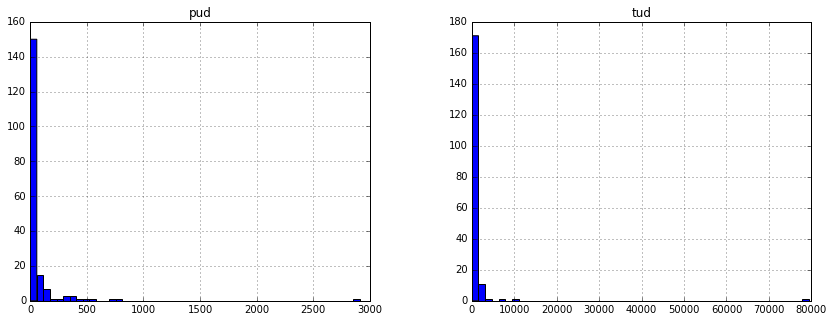

In [3]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.hist('pud', bins=50, ax=axs[0])
data.hist('tud', bins=50, ax=axs[1])

### PUD and TUD are correlated, but capture slightly different visitation patterns

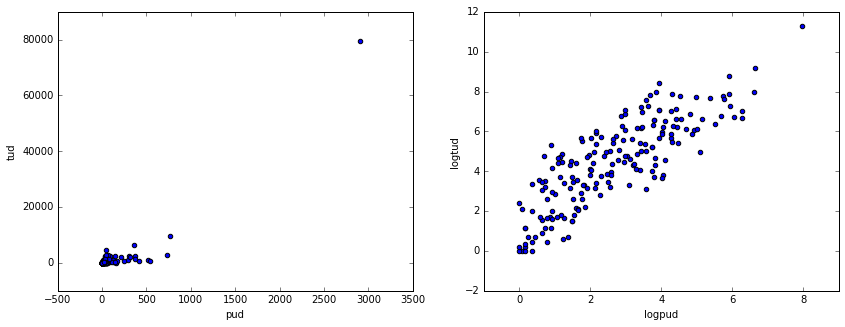

In [4]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pud', y='tud', ax=axs[0])
data.plot.scatter(x='logpud', y='logtud', ax=axs[1])

### PUD, TUD are influenced by area of PCA

In [7]:
# pca_shp = gpd.read_file('../pca_twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')
pca_shp = gpd.read_file('../pca_twitter/tud_nondissolved_pcas/shp/Priority_Conservation_Areas_current_pid.shp')

pca_shp['area_m2'] = pca_shp.area
data = data.merge(pca_shp[['area_m2', 'pid', 'name', 'joinkey', 'fipco']], on='pid')
data['logarea'] = np.log1p(data['area_m2'])
data['pud_per_m2'] = data['pud']/data['area_m2']
data['tud_per_m2'] = data['tud']/data['area_m2']

In [9]:
# data.hist('area_m2', bins=50)

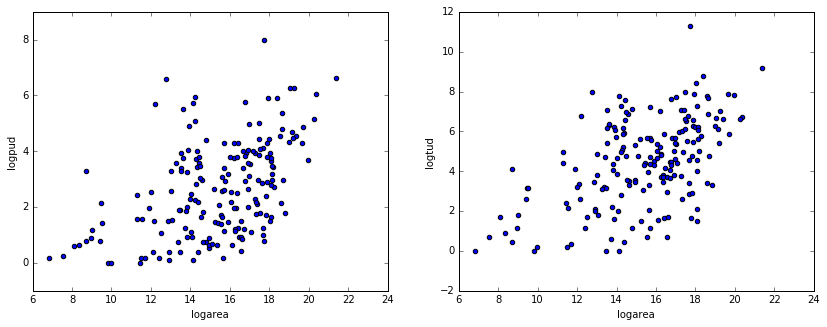

In [10]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='logarea', y='logpud', ax=axs[0])
data.plot.scatter(x='logarea', y='logtud', ax=axs[1])

### Add Designation type of each PCA to the table
NL = Natural Landscape  
AL = Agricultural Land  
UG = Urban Greening  
RR = Regional Recreation

In [11]:
designation = pd.read_csv('../pca/FINAL_List_of_165_PCAs_Designations.csv')
# Source: https://abag.ca.gov/priority/conservation/pdfs/FINAL_List_of_165_PCAs_Approved_as_of_September_2015.pdf

designation['NL'] = designation['Designation'].str.extract('(NL)')
designation['AL'] = designation['Designation'].str.extract('(AL)')
designation['UG'] = designation['Designation'].str.extract('(UG)')
designation['RR'] = designation['Designation'].str.extract('(RR)')
designation.fillna('', inplace=True)
designation['desig'] = designation['NL']+designation['AL']+designation['UG']+designation['RR']
designation.drop(labels='Designation', axis='columns', inplace=True)

data = pd.merge(data, designation, left_on='joinkey', right_on='Area ID', how='left')
data.to_csv('../pca/pca_vis_designation.csv', index=False)

#### joining data to shp to make some maps in qgis
shp = pca_shp.merge(data, on='pid')
shp.to_file('../pca/pca_current_visdata.shp')

/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None)

## PCA recreation by SLR scenarios
1) BCDC intersected the PCA polygons with the flood zone polygons for all SLR scenarios.  
2) We counted PUDs inside those flood areas for each scenario  
3) Results summarized here as the Proportion of PUDs outside the flood zone of each SLR scenario, for each PCA

In [24]:
def join_scenario_puds(scenario, mediaplatform, whole_pca_df):
    '''
    scenario (string): one of a list of directory names like
        '../bcdc_slr/PCAexposure_201710/slr_scenarios/12inches'
    mediaplatform (string): either 'flickr' or 'twitter' 
        these are subdirectories of 'scenario'
    whole_pca_df (pandas dataframe): it has PCA metadata like the name and total PUD/TUD
    '''    
    print(scenario)
    
    # table with userdays in the scenario polygons, keyed by pid
    spud = pd.read_csv(os.path.join(scenario, mediaplatform, "userdays_avg_annual_bypid_2005_2015.csv"))
    
    # table linking userdays id (pid) and scenario polygon id (FID_spjoin)
    # sometimes this table includes an 'area' column sometimes not, we won't use it
    pid_fidspjoin_crswlk = pd.read_csv(glob.glob(os.path.join(scenario, mediaplatform, '*_pid'))[0])
    pid_fidspjoin_crswlk = pid_fidspjoin_crswlk[['FID_spjoin', 'pid']]
    
    # table linking scenario polygon id (TARGET_FID) and master PCA unique id (joinkey, fipco)
    fidspjoin_joinkey_crswlk = gpd.read_file(glob.glob(os.path.join(scenario, 'spjoin*.dbf'))[0])
    fidspjoin_joinkey_crswlk = fidspjoin_joinkey_crswlk[['TARGET_FID', 'joinkey', 'fipco', 'name']]
    
    # joins to get scenario userdays linked to master PCA unique id (joinkey, fipco)
    spud_fid = pd.merge(spud, pid_fidspjoin_crswlk, on='pid')
    np.all(np.isnan(spud_fid['avg_ann_ud']))
    dat = pd.merge(spud_fid, fidspjoin_joinkey_crswlk, left_on='FID_spjoin', right_on='TARGET_FID')
    
    ## join scenario PUDs to whole PUDs
    dat2 = pd.merge(dat, whole_pca_df, on=['joinkey', 'fipco'], how='right')
    
    scen = os.path.basename(scenario)
    # proportion of PUD that are outside the flood zone
    dat2[scen] = 1 - dat2['avg_ann_ud']/dat2['pud'] ## !! hardcoded for PUD right now
    return(dat2[['joinkey', 'fipco', scen]])

In [13]:
data = pd.read_csv('../pca/pca_vis_designation.csv', dtype={'fipco': 'str'})
data['desig'].fillna('', inplace=True) # because some PCAs missing data in the original designation table
data['uid'] = data['joinkey']+data['fipco']

In [17]:
basedir = '../bcdc_slr/PCAexposure_201710/slr_scenarios/'
# for now excluding the FEMA 100yr & 500yr storm scenarios since they are not directly comparable to the SLR scenarios
scenarios = ['12inches', '24inches', '36inches',  '48inches', '52inches', '66inches', '77inches', '84inches', '96inches', '108inches']

In [25]:
results = []
for scen in scenarios:
    results.append(join_scenario_puds(os.path.join(basedir, scen), 'flickr', data))

# make single table
slrdata = reduce(lambda x, y: pd.merge(x, y, on = ['joinkey', 'fipco']), results)

# single key for PCAs
slrdata['uid'] = slrdata['joinkey']+slrdata['fipco']
slrdata.drop(labels=['joinkey', 'fipco'], axis='columns', inplace=True)
slrdata.set_index('uid', inplace=True)
slrdata['0inches'] = 1
scenario_labels = ['0inches'] + scenarios
slrdata = slrdata[scenario_labels]
slrdata.fillna(1, inplace=True)

numeric_index = [int(s.strip('inches')) for s in list(slrdata)]

../bcdc_slr/PCAexposure_201710/slr_scenarios/12inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/24inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/36inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/48inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/52inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/66inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/77inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/84inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/96inches
../bcdc_slr/PCAexposure_201710/slr_scenarios/108inches


In [34]:
# join some PCA metadata
pcaslr = pd.merge(slrdata, data[['uid', 'pud', 'name', 'desig']], left_index=True, right_on='uid', how='left')
# could also join the % area flooded calculations from BCDC's table.

pcaslr = pcaslr[['uid', 'name', 'pud'] + scenario_labels + ['desig']]
pcaslr.to_csv('../pca/pca_vis_slrscenarios_designation.csv', index=False)

#### Plotting

In [35]:
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20
from bokeh.models.tickers import FixedTicker
# from beakerx import *

In [36]:
pcaslr = pd.read_csv('../pca/pca_vis_slrscenarios_designation.csv')
scenario_labels = list(pcaslr)[3:14]
numeric_index = [int(s.strip('inches')) for s in scenario_labels]

In [37]:
pcaslr.sort_values(by=['pud'], ascending=False)

In [38]:
output_notebook()

pcafactors = list(set(pcaslr['desig']))

source = ColumnDataSource(data=dict(
            xs=[numeric_index]*len(pcaslr.index.values),
            ys=[pcaslr.loc[i, scenario_labels] for i in pcaslr.index.values],
            name=list(pcaslr['name']),
            pud=list(pcaslr['pud']),
            desig=list(pcaslr['desig'])
        )) 

p = figure(width=900, height=400, x_range=(-1,110),
           title='Each line is a PCA',
            x_axis_label = "inches of sea-level-rise",
            y_axis_label = "proportion of PUD outside the flood zone")
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.multi_line(xs='xs',
                ys='ys',
                source=source,
                line_color='red',
#                 line_color=factor_cmap('desig', palette=Category20[len(pcafactors)], factors=pcafactors),
                line_alpha=0.4,
                line_width=1)

p.xaxis.ticker = FixedTicker(ticks=numeric_index)

p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('PCA', '@name'),
    ('Total PUD', '@pud'),
    ('Type', '@desig')
]))

# p.legend.orientation = "vertical"
# p.legend.location = "right"

show(p, notebook_handle=True)

Loading BokehJS ...

#### General questions about area or amount of the PCA network exposed to SLR are answered in BCDC's PCA-Exposure analysis